# Pytorch Tutoral - Autograd & MLP(Multi-layer perceptron)

# Autograd

- `autograd`패키지는 텐서의 모든 연산에 대한 자동 미분을 제공
- 실행-기반-정의(define-by-run) 프레임워크로, 코드를 어떻게 작성하여 실행하느냐에 따라 역전파가 정의된다는 것을 의미
- 역전파는 학습 과정의 매 단계마다 달라짐


## Tensor

- `torch.Tensor` 클래스의 `.requires_grad` 속성을 `True`로 설정하면, 해당 텐서에서 이루어진 모든 연산을 추적(track)하기 시작
- 계산이 완료된 후 `.backward()`를 호출하여 모든 변화도(gradient)를 자동으로 계산할 수 있으며 이 Tensor의 변화도는 `.grad` 속성에 누적됨
- Tensor가 기록을 추적하는 것을 중단하게 하려면, `.detach()`를 호출하여 연산기록으로부터 분리하여 연산이 추적되는 것을 방지할 수 있음
- 기록을 추적하는 것(과 메모리를 사용하는 것)을 방지하기 위해서 코드 블럭을 `with torch.no_grad():`로 감쌀 수 있음
- 이는 변화도(gradient)는 필요 없지만 `requires_grad=True`가 설정되어 학습 가능한 매개변수를 갖는 모델을 평가(evaluate)할 때 유용
- Autograd 구현에서 `Function` 클래스는 매우 중요한 역할을 수행
- `Tensor`와 `Function`은 서로 연결되어 있고 모든 연산 과정을 부호화하여 순환하지 않는 그래프를 생성
- 각 tensor는 `.grad_fn` 속성을 가지고 있는데 이는 `Tensor`를 생성한 `Function`을 참조함(단, 사용자가 만든 Tensor는 예외이며, 사용자가 만든 Tensor가 아닌 연산에 의해 생긴 텐서와 같은 경우는 모두 `Function`을 참조)
- 도함수를 계산하기 위해서는 `Tensor`의 `.backward()`를 호출하면 됨

In [1]:
import torch

print(torch.__version__)

1.10.2+cu102


In [2]:
# x의 연산 과적을 추적하기 위해 requires_grad=True로 설정
x = torch.ones(2, 2, requires_grad=True)
print(x)

# 직접 생선한 Tensor이기 때문에 grad_fn이 None인 것을 확인할 수 있음
print(x.grad_fn)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None


In [3]:
# y는 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖고 있는 것을 확인 가능
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [4]:
# 연산의 결과로 생성된 것이기 때문에 grad_fn을 갖는 것을 확인 가능
print(y.grad_fn)

In [5]:
z = y * y * 3
out = z.mean()

# 각각 사용한 func에 맞게 grad_fn이 생성된 것을 확인할 수 있음
print(z)
print(out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>)
tensor(27., grad_fn=<MeanBackward0>)


- `requires_grad_()`를 사용하면 기존 Tensor의 `requires_grad` 값을 바꿀 수 있음
- 입력 값이 지정되지 않으면 기본 값은 `False`

In [6]:
a = torch.randn(2, 2)
print(a)

tensor([[-0.5434, -1.0227],
        [-0.3448, -2.2716]])


In [7]:
a = ((a * 3) / (a - 1))
print(a)
print(a.requires_grad)

tensor([[1.0562, 1.5169],
        [0.7691, 2.0830]])
False


In [8]:
a.requires_grad_(True)

tensor([[1.0562, 1.5169],
        [0.7691, 2.0830]], requires_grad=True)

In [9]:
print(a.requires_grad)

True


In [10]:
b = (a * a).sum()
print(b)
print(b.requires_grad)

tensor(8.3469, grad_fn=<SumBackward0>)
True


## 변화도(Gradient)

- 참조: https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29

- 일반적으로 torch.autograd는 vector-Jacobian product를 계산하기 위해 사용된다. 수학적으로, $y = f(x)$(하나의 레이어라고 생각하자)에서 y의 x에 대한 gradient는 (x, y가 matrix일때) Jacobian으로 나타난다. 이를 J라고 하자. autograd를 어떠한 벡터 $v^T$가 주어질 때, $v^T J$를 계산하는 데에 사용할 것이다.
- 이는 다음과 같이 활용된다. $l = g(y)$일 때, l의 y에 대한 기울기를 $v^T$라고 하면, l의 x에 대한 기울기는 $v^T J$로 나타내진다. 여기서, `y.backward(gradient)`는 곧 $v^T J$를 output으로 나타내며, 이것이 `x.grad` 값이 된다. 그러므로 `.backward(gradient=???)`의 `gradient` argument는 $v^T$를 사용자가 설정하여 지정해줄 수 있는 값을 의미하는 것이다. `gradient`의 default값은 `torch.tensor(1.)`이다.
- `loss.backward()`와 같이 인자를 따로 제공하지 않고 사용하는 경우가 많으나, 이는 loss값이 **scala인 경우에만 가능**하다. 물론 loss값이 scala라도 따로 gradient를 마찬가지의 shape인 scala tensor로 별도 제공할 수도 있다.
- 단 loss와 같이 backward()의 실행 대상이 되는 **output tensor**(여기서는 loss)가 **벡터로 주어지는 경우, 반드시 `gradient=torch.Tensor([])`를 제공**해야한다. 이는 output 텐서의 shape와 동일해야 한다.

In [12]:
print(out)

# 이전에 만든 out을 사용해서 역전파 진행

y.retain_grad()     # 중간 값에 대한 미분 값을 보고싶다면 해당 값에 대한 retain_grad()를 호출해야 함
z.retain_grad()
out.backward()      # 여러 번 미분을 진행하기 위해서는 retain_graph=True로 설정해줘야 함(그렇지 않으면 아래처럼 에러 발생)

# out.backward(torch.tensor(1.))을 진행하는 것과 동일
# TensorA.backward(gradient=TensorB): gradient로 주어지는 TensorB는 TensorA와 같은 shape로, TensorA 자기 자신의 기울기(gradient)를 제공한다.
print(x.grad)
print(y.grad)
print(z.grad)
print(z.is_leaf)     # leaf node인지 확인

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [13]:
x = torch.ones(2, 2, requires_grad=True)
y = x + 2
z = y * y * 3
out = z.mean()

print(out)

y.retain_grad()
out.backward(retain_graph=True)

print(x.grad)
print(y.grad)
print(z.grad)       # z.retain_grad()를 호출하지 않으면 grad값을 저장하지 않기 때문에 grad 속성을 볼 수 없음
print(z.is_leaf)

out.backward()
print(x.grad)
print(y.grad)

tensor(27., grad_fn=<MeanBackward0>)
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])
None
False
tensor([[9., 9.],
        [9., 9.]])
tensor([[9., 9.],
        [9., 9.]])


/home/hanoul/.pyenv/versions/3.8.2/envs/initial_env/lib/python3.8/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


$$ out = \frac{1}{4} \sum_{i} z_i $$
$$ z_i = 3(x_i + 2)^2 $$
- `z_i`를 미분한 값에 적용하면 4.5를 동일하게 출력할 수 있음






out(미분결과) = 1/4 * 6 * (x + 2) = 3/2(x+2) 



---




- 일반적으로 `torch.autograd`는 벡터-야코비안 곱을 계산하는 엔진
- `torch.autograd`를 사용하면 전체 야코비안을 직접 계산할 수는 없지만, 벡터-야코비안 곱은 `backward`에 해당 벡터를 인자로 제공하여 얻을 수 있음

In [14]:
x = torch.randn(3, requires_grad=True)

y = x * 2

while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([-1123.6415,  -214.0234,   771.3936], grad_fn=<MulBackward0>)


In [15]:
# scalar값이 아닌 y의 벡터-야코비안 곱을 구하는 과정
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([5.1200e+01, 5.1200e+02, 5.1200e-02])


- `with torch.no_grad()`로 코드 블록을 감싸서 `autograd`가 `.requires_grad=True`인 Tensor의 연산 기록을 추적하는 것을 멈출 수도 있음

In [17]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


- 또는 `.detach()`를 호출하여 내용물은 같지만 `requires_grad`가 다른 새로운 텐서를 가져올 수 있음

In [19]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all()) # tesorA.eq(tensorB) : tensor A, B가 동일한지 확인

True
False
tensor(True)


# ANN(Artificial Neural Networks)

- 신경망은 `torch.nn` 패키지를 사용하여 생성할 수 있음
- `nn`은 모델을 정의하고 미분하기 위해서 위에서 살펴본 `autograd`를 사용
- `nn.Module`은 계층(layer)과 `output`을 반환하는 `forward(input)` 메소드를 포함



---



- 간단한 순전파 네트워크(feed-forward-network)
- 입력을 받아 여러 계층에 차례로 전달한 후, 최종 출력을 제공
- 신경망의 일반적인 학습 과정


> - 학습 가능한 매개변수(가중치)를 갖는 신경망을 정의
> - 데이터 셋 입력을 반복
> - 입력을 신경망에서 전파(process)
> - 손실(loss; 입력 값과 예측 값과의 차이)를 계산
> - 변화도(gradient)를 신경망의 매개변수들에 역으로 전파 - 역전파 과정
> - 신경망의 가중치를 갱신
> > - `새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)`



In [20]:
import pandas as pd

from sklearn.datasets import load_iris

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [21]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128) # Batch nomalization. 배치 단위의 값들을 정규화하여 값이 너무 튀지않도록 함
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
        
        x = self.act(self.bn0(self.layer0(x)))
        x = self.act(self.bn1(self.layer1(x)))
        x = self.act(self.bn2(self.layer2(x)))
        x = self.act(self.layer3(x))
        x = self.layer4(x)

        return x

## 손실 함수(Loss Function)

- 손실 함수는 (output, target)을 한 쌍으로 입력 받아, 출력이 정답으로부터 얼마나 떨어져있는지 추정하는 값을 계산


- `forward`함수만 정의하고 나면 `backward`함수는 `autograd`를 사용하여 자동으로 정의됨
- 모델의 학습 가능한 매개 변수는 `net.parameters()`에 의해 변환됨

### Leaf Node와 .grad
- requires_grad가 False인 Tensor는 보통 leaf Tensor가 됨
- reauires_grad가 True이고, 사용자가 직접 만든 경우 leaf Tensor가 됨. 이 때는 연산의 결과가 아니므로 grad_fn이 None

- leaf Tensor만이 backward()시 grad를 구성함
- leaf Tensor가 아닌 Tensor에 대해 grad를 구성하려면, retain_grad를 사용

- Computational Graph의 leaf node라는 뜻
- Computational Graph에 포함되지 않는 node 역시 leaf node. Pytorch의 computation graph를 그릴 때 각 노드에 실제로 들어가는 것은 tensor의 grad_fn이다

- 정리하자면, Tensor의 is_leaf가 True이고 required_grad가 True인 경우에 grad에 값이 저장된다.
- 연산에 의해서 만들어진 Tensor는 grad_fn을 갖기 때문에, 사용자가 생성하고 required_grad=True인 Tensor들이 grad를 가진 주요 대상이라고 할 수 있다.

In [22]:
# 랜덤 값 생성
criterion = nn.CrossEntropyLoss() # 손실함수: 크로스엔트로피(다중분류에 주로 사용)

ex_X, ex_y = torch.randn([4, 4]), torch.tensor([1, 0, 2, 0]) # 랜덤 input과 정답 레이블

net = Net()
output = net(ex_X)
loss = criterion(output, ex_y)
print('loss: ', loss.item())
  
net.zero_grad() # 학습 전 gradient 우선 초기화

print('layer0.bias.grad before backward')
print(net.layer4.bias.grad)

print(net.layer4.bias.is_leaf)

loss.backward() # 역전파(gradient 구하기)

print('layer0.bias.grad after backward')
print(net.layer4.bias.grad)

"""
이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 노드이기 때문이라고 합니다.
설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)

어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20
왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7
"""

loss:  1.0904805660247803
layer0.bias.grad before backward
None
True
layer0.bias.grad after backward
tensor([-0.1551,  0.0273,  0.1278])


'\n이 부분에서 .retain_grad() 를 사용하지 않아도 되는 이유는 weight와 bias의 파라미터가 leaf 노드이기 때문이라고 합니다.\n설명이 포함된 링크들을 아래에 첨부해두니 읽어보시면 좋을 것 같습니다 :)\n\n어떤 경우가 leaf 노드 인지 - https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/20\n왜 leaf 노드인 경우에는 retain_grad()를 하지 않아도 grad 값이 나오는지 - https://discuss.pytorch.org/t/what-is-the-purpose-of-is-leaf/87000/7\n'

In [23]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # layer0의 weight

16
torch.Size([128, 4])


## 가중치 갱신
- 가장 단순한 갱신 규칙은 확률적 경사하강법(SGD; Stochastic Gradient Descent)
- `새로운 가중치(weight) = 가중치(weight) - 학습률(learning rate) * 변화도(gradient)`

In [24]:
# torch.optim 패키지에 다양한 갱신 규칙이 규현되어 있음

import torch.optim as optim

# optimizer setting
optimizer = optim.SGD(net.parameters(), lr=0.001)
optimizer.zero_grad()

# SGD update
output = net(ex_X)
loss = criterion(output, ex_y)
loss.backward()
optimizer.step()  # 업데이트 진행

## MLP 모델

In [25]:
dataset = load_iris()

data = dataset.data
label = dataset.target

print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [26]:
print('shape of data: ', data.shape)
print('shape of label: ',label.shape)

shape of data:  (150, 4)
shape of label:  (150,)


In [30]:
# 훈련과 테스트 데이터로 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25)
print(len(X_train))
print(len(X_test))

112
38


In [31]:
# DataLoader 생성
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()

train_set = TensorDataset(X_train, y_train) # torch의 Dataset Class 중 Tensor 데이터를 다루는 Dataset

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

In [32]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.layer0 = nn.Linear(4, 128)
        self.layer1 = nn.Linear(128, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 3)

        self.bn0 = nn.BatchNorm1d(128)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)

        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.bn0(self.layer0(x)))
        x = self.act(self.bn1(self.layer1(x)))
        x = self.act(self.bn2(self.layer2(x)))
        x = self.act(self.layer3(x))
        x = self.layer4(x)

        return x
      # return nn.Softmax(x)

In [33]:
net = Net()
print(net)

Net(
  (layer0): Linear(in_features=4, out_features=128, bias=True)
  (layer1): Linear(in_features=128, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=3, bias=True)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU()
)


In [34]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 200

In [35]:
losses = list()
accuracies = list()

for epoch in range(epochs):
  epoch_loss = 0  
  epoch_accuracy = 0
  for X, y in train_loader:
  
    optimizer.zero_grad()
    
    output = net(X)

    loss = criterion(output, y)
    loss.backward()
    
    optimizer.step()
    # output = [0.11, 0.5, 0.8]  --> 예측 클래스 값
    _, predicted = torch.max(output, dim=1)
    accuracy = (predicted == y).sum().item()
    epoch_loss += loss.item()
    epoch_accuracy += accuracy
  

  epoch_loss /= len(train_loader)
  epoch_accuracy /= len(X_train)
  print("epoch :{}, \tloss :{}, \taccuracy :{}".format(str(epoch+1).zfill(3),round(epoch_loss,4), round(epoch_accuracy,4)))
  
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

epoch :001, 	loss :1.0817, 	accuracy :0.4018
epoch :002, 	loss :1.0645, 	accuracy :0.4911
epoch :003, 	loss :1.0544, 	accuracy :0.5357
epoch :004, 	loss :1.0488, 	accuracy :0.6161
epoch :005, 	loss :1.0278, 	accuracy :0.6607
epoch :006, 	loss :1.045, 	accuracy :0.5982
epoch :007, 	loss :1.0234, 	accuracy :0.6696
epoch :008, 	loss :1.0032, 	accuracy :0.7946
epoch :009, 	loss :1.013, 	accuracy :0.6786
epoch :010, 	loss :1.0048, 	accuracy :0.6786
epoch :011, 	loss :1.0024, 	accuracy :0.7143
epoch :012, 	loss :0.9703, 	accuracy :0.7679
epoch :013, 	loss :0.9907, 	accuracy :0.6964
epoch :014, 	loss :0.9748, 	accuracy :0.7232
epoch :015, 	loss :0.9583, 	accuracy :0.75
epoch :016, 	loss :0.9677, 	accuracy :0.6964
epoch :017, 	loss :0.9263, 	accuracy :0.7589
epoch :018, 	loss :0.9049, 	accuracy :0.8214
epoch :019, 	loss :0.9407, 	accuracy :0.6964
epoch :020, 	loss :0.9042, 	accuracy :0.7411
epoch :021, 	loss :0.919, 	accuracy :0.7321
epoch :022, 	loss :0.9271, 	accuracy :0.6964
epoch :023, 	lo

epoch :185, 	loss :0.5116, 	accuracy :0.8482
epoch :186, 	loss :0.5715, 	accuracy :0.7857
epoch :187, 	loss :0.4377, 	accuracy :0.8304
epoch :188, 	loss :0.4204, 	accuracy :0.8214
epoch :189, 	loss :0.4993, 	accuracy :0.7679
epoch :190, 	loss :0.4329, 	accuracy :0.8571
epoch :191, 	loss :0.4487, 	accuracy :0.8304
epoch :192, 	loss :0.493, 	accuracy :0.8036
epoch :193, 	loss :0.4261, 	accuracy :0.8393
epoch :194, 	loss :0.4005, 	accuracy :0.8393
epoch :195, 	loss :0.4442, 	accuracy :0.8571
epoch :196, 	loss :0.4536, 	accuracy :0.8125
epoch :197, 	loss :0.5917, 	accuracy :0.7411
epoch :198, 	loss :0.3952, 	accuracy :0.8393
epoch :199, 	loss :0.4598, 	accuracy :0.8482
epoch :200, 	loss :0.5104, 	accuracy :0.7946


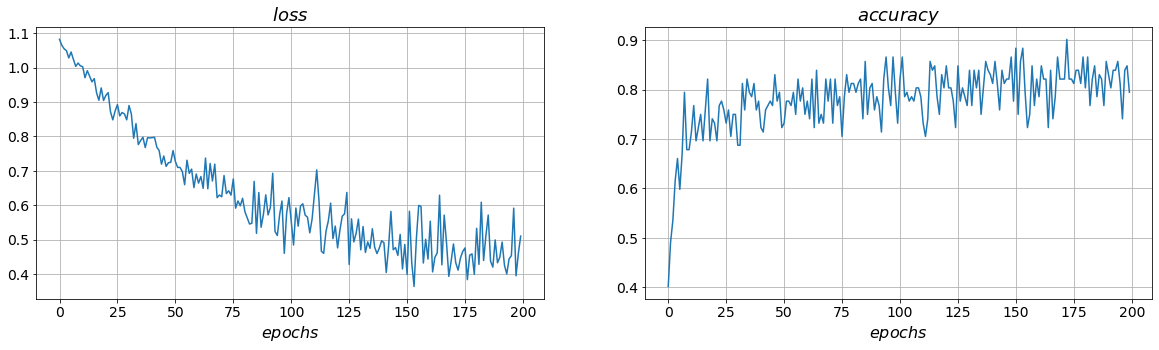

In [36]:
# Plot result

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1,2,1)
plt.title("$loss$",fontsize = 18)
plt.plot(losses)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)


plt.subplot(1,2,2)
plt.title("$accuracy$", fontsize = 18)
plt.plot(accuracies)
plt.grid()
plt.xlabel("$epochs$", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.show()

In [38]:
# Test

output = net(X_test)
print(torch.max(output, dim=1))
_, predicted = torch.max(output, dim=1)
accuracy = round((predicted == y_test).sum().item() / len(y_test),4)


print("test_set accuracy :", round(accuracy,4))

torch.return_types.max(
values=tensor([1.3195, 0.8905, 2.2739, 2.8837, 2.1053, 4.1774, 1.2014, 3.5647, 0.9119,
        1.9835, 2.1319, 0.8484, 1.9893, 1.5382, 2.1648, 0.8038, 2.9274, 1.1330,
        1.4533, 3.2502, 1.9343, 3.6618, 1.8325, 1.5858, 1.4769, 1.5968, 1.9140,
        2.3784, 2.2139, 2.6875, 2.4226, 1.9942, 1.3493, 2.5701, 1.1772, 3.4934,
        2.9197, 2.2681], grad_fn=<MaxBackward0>),
indices=tensor([1, 2, 0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 2,
        1, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 0, 0, 2]))
test_set accuracy : 0.9474
